# Why doesn't L1 error decay with number of measurements?

- Maybe measurement error exceeds the tolerance sometimes. This means that the error will likely increase the estimated influence of the low influence examples. Try dual optimization or investigate residual tolerance and algorithms.
- Maybe measurement matrix has high coherence or bad restricted isometry bounds. This doesn't imply bad recovery though. Try Gaussian matrices.
- Maybe the ground truth vector is not sparse enough. Try a simpler ground truth with exact sparsity.

### Variables
- sparsity of ground truth vector ($s$-sparse, low sparsity defect with long tail or no long tail)
- measurement matrix (Gaussian, bounded Gaussian < 1, random subset, random binary, uniform)
- measurement noise
- optimization algorithm (and residual tolerance for QCBP)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import pearsonr

import IPython

sns.set(color_codes=True)
plt.style.use('seaborn')

import cvxpy
from tqdm import tqdm

In [2]:
def generate_only_once(func):
    cache = {}
    def wrapper(*args, **kwargs):
        key = tuple(args) + tuple(kwargs.items())
        if key not in cache:
            cache[key] = func(*args, **kwargs)
        return cache[key]
    
    return wrapper

In [3]:
def truncate_x(values, truncate):
    mask = np.random.uniform(0, 1, size=(len(values),))
    values[np.argsort(mask)[truncate:]] = 0
    return values

@generate_only_once
def generate_uniform_x(n, truncate=None):
    truncate = n if truncate is None else truncate
    return truncate_x(np.random.uniform(-1, 1, size=(n,)), truncate)

@generate_only_once
def generate_gaussian_x(n, truncate=None, sigma=1):
    truncate = n if truncate is None else truncate
    return truncate_x(np.random.normal(0, sigma, size=(n,)), truncate)

@generate_only_once
def generate_exponential_x(n, truncate=None, scale=1, power=2):
    truncate = n if truncate is None else truncate
    return truncate_x(np.random.exponential(scale, size=(n,)) ** power, truncate)

def sparsity_defect(x_gt, ax=None, measurement_samples=20):
    n = len(x_gt)
    
    # Try using different numbers of measurements
    measurements = np.arange(n, 0, -max(n // measurement_samples, 1))
    sparsity_defect = np.zeros(len(measurements))
    
    for i, M in enumerate(measurements):
        s = M // 2
        order = np.argsort(np.abs(x_gt))
        sparsity_defect[i] = np.sum(np.abs(x_gt[order[:-s]]))
    
    if ax is None:
        ax = plt.figure(figsize=(16, 6)).gca()
    
    ax.plot(measurements, sparsity_defect, marker='o')
    ax.set_title("Sparsity defect for s = measurements/2")
    ax.set_xlabel('measurements')
    ax.set_ylabel('Sparsity defect')

In [54]:
@generate_only_once
def generate_uniform_A(n, m):
    return np.random.uniform(0, 1, size=(m, n))

@generate_only_once
def generate_gaussian_A(n, m, sigma=1):
    return np.random.normal(0, sigma, size=(m, n))

@generate_only_once
def generate_bounded_gaussian_A(n, m, sigma=1):
    return np.minimum(1.0, np.random.normal(0, sigma, size=(m, n)))

@generate_only_once
def generate_random_binary_A(n, m, p=0.5):
    return np.random.binomial(1, 0.5, (m, n)) # 0/1, not -1/1

@generate_only_once
def generate_random_subset_A(n, m, k=10):
    A = np.zeros((m, n))
    for i in range(m):
        A[i, np.random.choice(np.arange(n))] = 1
    return A

In [5]:
def simulate_exact(A, x_gt):
    return np.dot(A, x_gt)

def simulate_uniform(A, x_gt, scale=1e-2):
    return np.dot(A, x_gt) + np.random.uniform(-scale, scale, size=(A.shape[0],))

def simulate_gaussian(A, x_gt, sigma=1e-3):
    return np.dot(A, x_gt) + np.random.normal(0, sigma, size=(A.shape[0],))

def simulate_gaussian_zero_gap(A, x_gt, sigma=1e-3, gap=1e-4):
    noise = np.random.normal(0, sigma, size=(A.shape[0],))
    noise[noise > 0] += 2 * gap
    noise -= gap
    return np.dot(A, x_gt) + noise

In [6]:
def basis_pursuit(A, y):
    x = cvxpy.Variable(A.shape[1])
    objective = cvxpy.Minimize(cvxpy.sum_entries(cvxpy.abs(x)))
    constraints = [ A * x == y ]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve()
    if problem.status == 'optimal':
        return np.array(x.value).reshape(-1)
    else:
        return None

def qc_basis_pursuit(A, y, eta=1e-3):
    x = cvxpy.Variable(A.shape[1])
    objective = cvxpy.Minimize(cvxpy.sum_entries(cvxpy.abs(x)))
    constraints = [ cvxpy.norm(A * x - y) < eta ]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve()
    if problem.status == 'optimal':
        return np.array(x.value).reshape(-1)
    else:
        return None

In [46]:
def error_against_measurements(A, x_gt, y,
    x_desc, A_desc, y_desc, alg_desc,
    ax=None,
    measurement_samples=20,
    sparse_recovery_alg=basis_pursuit, sparse_recovery_args={}):
    
    exp_desc = "n={}, x={}, A={}, y={}, alg={}".format(len(x_gt), x_desc, A_desc, y_desc, alg_desc)
    
    # Try using different numbers of measurements
    m = A.shape[0]
    measurements = np.arange(m, 0, -max(m // measurement_samples, 1))
    metrics = [
        ("L1", lambda d: np.sum(np.abs(d))),
        ("L2", lambda d: np.sqrt(np.sum(d ** 2))),
        ("Linf", lambda d: np.max(np.abs(d))),
    ]
    
    errors = np.zeros((len(measurements), len(metrics)))
    t = tqdm(enumerate(measurements))
    for i, M in t:
        t.set_description("{} measurements for {}".format(M, exp_desc))
        x = sparse_recovery_alg(A[:M, :], y[:M], **sparse_recovery_args)
        if x is not None:
            errors[i, :] = [ metric_f(x - x_gt) for name, metric_f in metrics ]
        else:
            errors[i, :] = np.nan
    
    if ax is None:
        ax = plt.figure(figsize=(16, 6)).gca()
    
    for i, metric in enumerate(metrics):
        ax.plot(measurements, errors[:, i], marker='o', label=metric[0])

    ax.set_title("Sparse recovery, {}".format(exp_desc))
    ax.set_xlabel('measurements')
    ax.set_ylabel('error')
    ax.legend()

In [8]:
def experiment(config, ax=None):
    n = config['n']
    m = config['m']
    measurement_samples = config.get('measurement_samples', 20)
    
    x_desc = '' if config['x']['truncate'] is None else '{}-sparse '.format(config['x']['truncate'])
    if config['x']['type'] == 'uniform':
        x_gt = generate_uniform_x(n, truncate=config['x']['truncate'])
        x_desc += "uniform"
    elif config['x']['type'] == 'gaussian':
        x_gt = generate_gaussian_x(n, truncate=config['x']['truncate'])
        x_desc += "gaussian"
    elif config['x']['type'] == 'exponential':
        scale, power = config['x']['scale'], config['x']['power']
        x_gt = generate_exponential_x(n, truncate=config['x']['truncate'], scale=scale, power=power)
        x_desc += "exp({})^{}".format(scale, power)
    
    A_desc = config['A']['type']
    if config['A']['type'] == 'uniform':
        A = generate_uniform_A(n, m)
    elif config['A']['type'] == 'gaussian':
        A = generate_gaussian_A(n, m)
    elif config['A']['type'] == 'bounded-gaussian':
        A = generate_bounded_gaussian_A(n, m)
    elif config['A']['type'] == 'binary':
        A = generate_random_binary_A(n, m)
    elif config['A']['type'] == 'subset':
        k = config['A']['k']
        A = generate_random_subset_A(n, m, k)
        A_desc = '{}-subset'.format(k)
        
    y_desc = config['y']['type']
    if config['y']['type'] == 'exact':
        y = simulate_exact(A, x_gt)
    elif config['y']['type'] == 'uniform':
        scale = config['y']['scale']
        y = simulate_uniform(A, x_gt, scale)
        y_desc += '({})'.format(scale)
    elif config['y']['type'] == 'gaussian':
        sigma = config['y']['sigma']
        y = simulate_gaussian(A, x_gt, sigma)
        y_desc += '({})'.format(sigma)
    elif config['y']['type'] == 'gaussian-gap':
        sigma = config['y']['sigma']
        gap = config['y']['gap']
        y = simulate_gaussian_zero_gap(A, x_gt, sigma, gap)
        y_desc += '({}, {})'.format(sigma, gap)
        
    alg_desc = config['alg']['type']
    if config['alg']['type'] == 'bp':
        alg = basis_pursuit
        alg_args = {}
    elif config['alg']['type'] == 'qcbp':
        eta = config['alg']['eta']
        alg = qc_basis_pursuit
        alg_args = { 'eta': eta }
        alg_desc += '({})'.format(eta)
    
    error_against_measurements(A, x_gt, y, x_desc, A_desc, y_desc, alg_desc, ax=ax,
        measurement_samples=measurement_samples,
        sparse_recovery_alg=alg, sparse_recovery_args=alg_args)

In [50]:
def experiment_grid(base_config, updates):
    fig, axs = plt.subplots(len(updates), 1, figsize=(16, 6 * len(updates)), sharex=True)
    axs = axs if len(updates) > 1 else [axs]
    for i, ax in enumerate(axs):
        config = base_config.copy()
        config.update(updates[i])
        experiment(config, ax)

## What kind of vectors are we looking at?

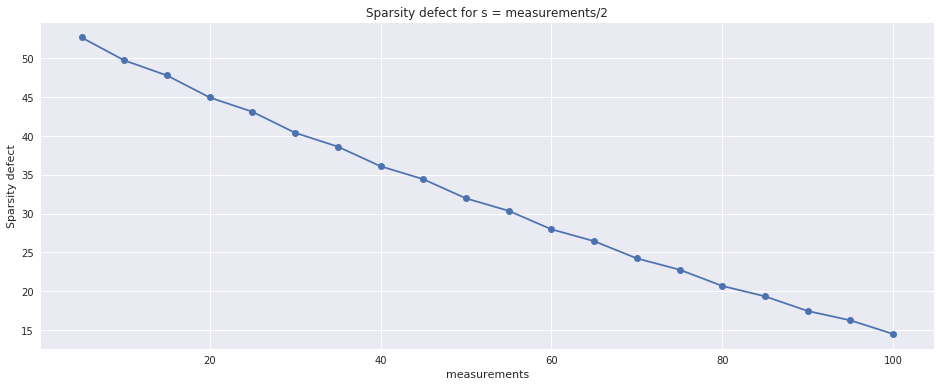

In [10]:
sparsity_defect(generate_uniform_x(100))

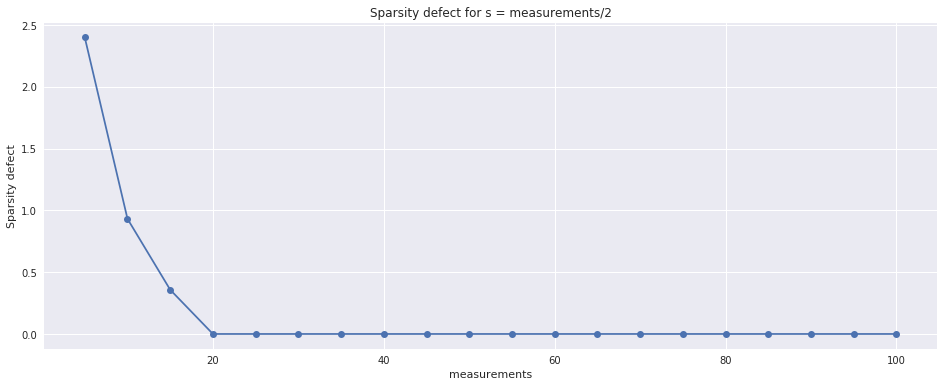

In [11]:
sparsity_defect(generate_uniform_x(100, truncate=10))

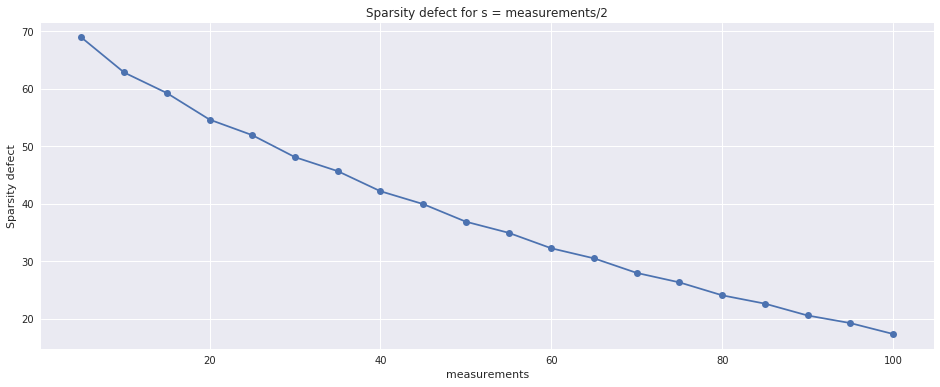

In [12]:
sparsity_defect(generate_gaussian_x(100))

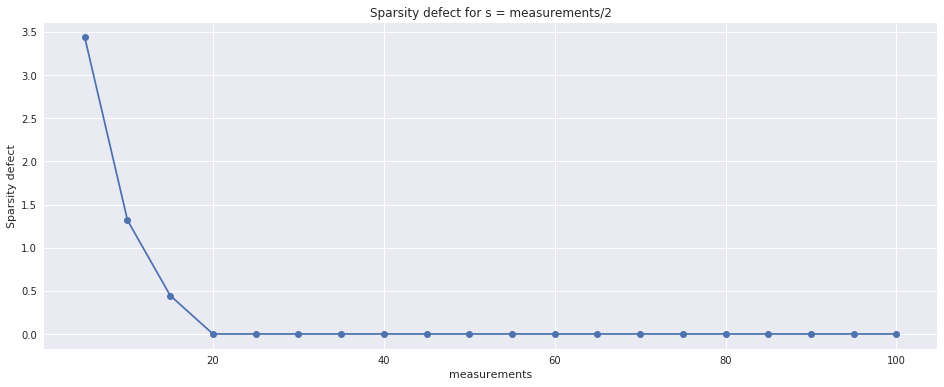

In [13]:
sparsity_defect(generate_gaussian_x(100, truncate=10))

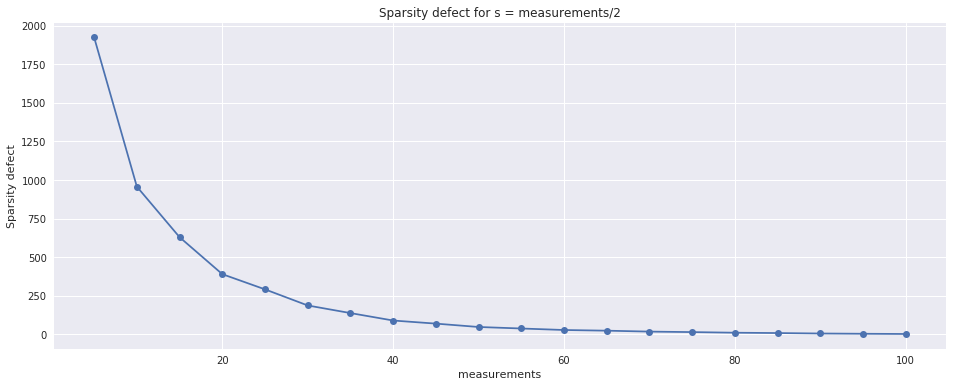

In [14]:
sparsity_defect(generate_exponential_x(100, scale=1, power=5))

So the low-sparsity-defect ground-truth generated by raising an exponential distribution to some power most closely fits the sparsity defect curve of our actual influence vector.

## Sanity check: $s$-sparse ground truth

2 measurements for n=100, x=10-sparse uniform, A=gaussian, y=exact, alg=bp: : 25it [00:00, 117.66it/s]


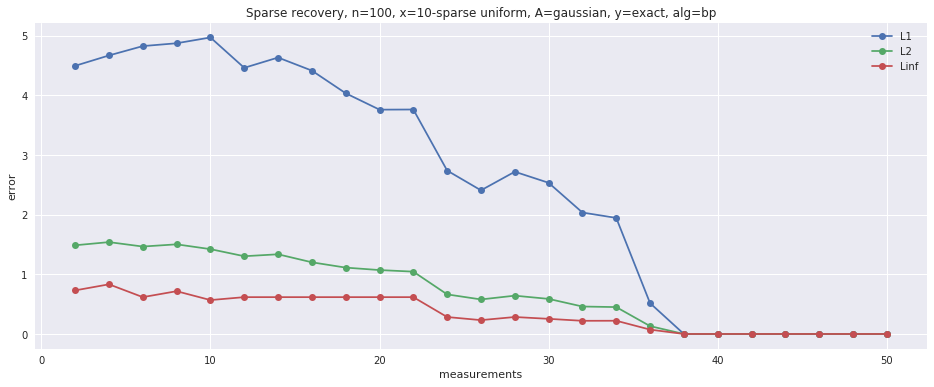

In [15]:
experiment({
    'n': 100, 'm': 50,
    'x': { 'type': 'uniform', 'truncate': 10 },
    'A': { 'type': 'gaussian' },
    'y': { 'type': 'exact' },
    'alg': { 'type': 'bp' },
})

Why is there no exact recovery at $m = 2s = 20$?

2 measurements for n=100, x=10-sparse uniform, A=gaussian, y=exact, alg=qcbp(0.001): : 25it [00:00, 86.51it/s] 
2 measurements for n=100, x=10-sparse uniform, A=gaussian, y=exact, alg=qcbp(0.01): : 25it [00:00, 91.10it/s] 
2 measurements for n=100, x=10-sparse uniform, A=gaussian, y=exact, alg=qcbp(0.1): : 25it [00:00, 89.66it/s] 


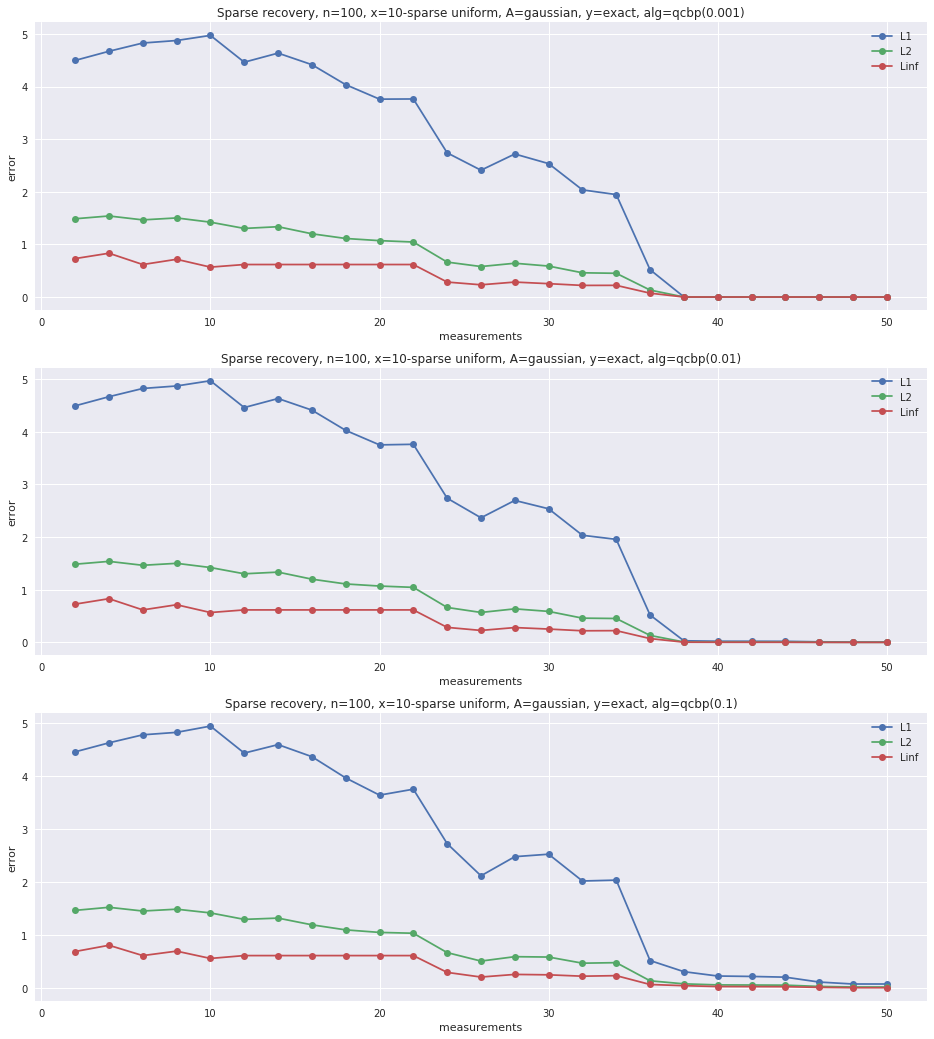

In [16]:
experiment_grid({
    'n': 100, 'm': 50,
    'x': { 'type': 'uniform', 'truncate': 10 },
    'A': { 'type': 'gaussian' },
    'y': { 'type': 'exact' },
    'alg': { 'type': 'bp' },
}, [
    { 'alg': { 'type': 'qcbp', 'eta': 1e-3 } },
    { 'alg': { 'type': 'qcbp', 'eta': 1e-2 } },
    { 'alg': { 'type': 'qcbp', 'eta': 1e-1 } },
])

BP and QCBP are both equally good are recovering an actual sparse vector with a Gaussian matrix. Tolerance for QCBP also doesn't really matter.

## Less-sparse ground truths

1 measurements for n=100, x=10-sparse gaussian, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 56.49it/s] 
1 measurements for n=100, x=20-sparse gaussian, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 54.36it/s] 
1 measurements for n=100, x=30-sparse gaussian, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 56.48it/s] 
1 measurements for n=100, x=gaussian, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 57.57it/s] 


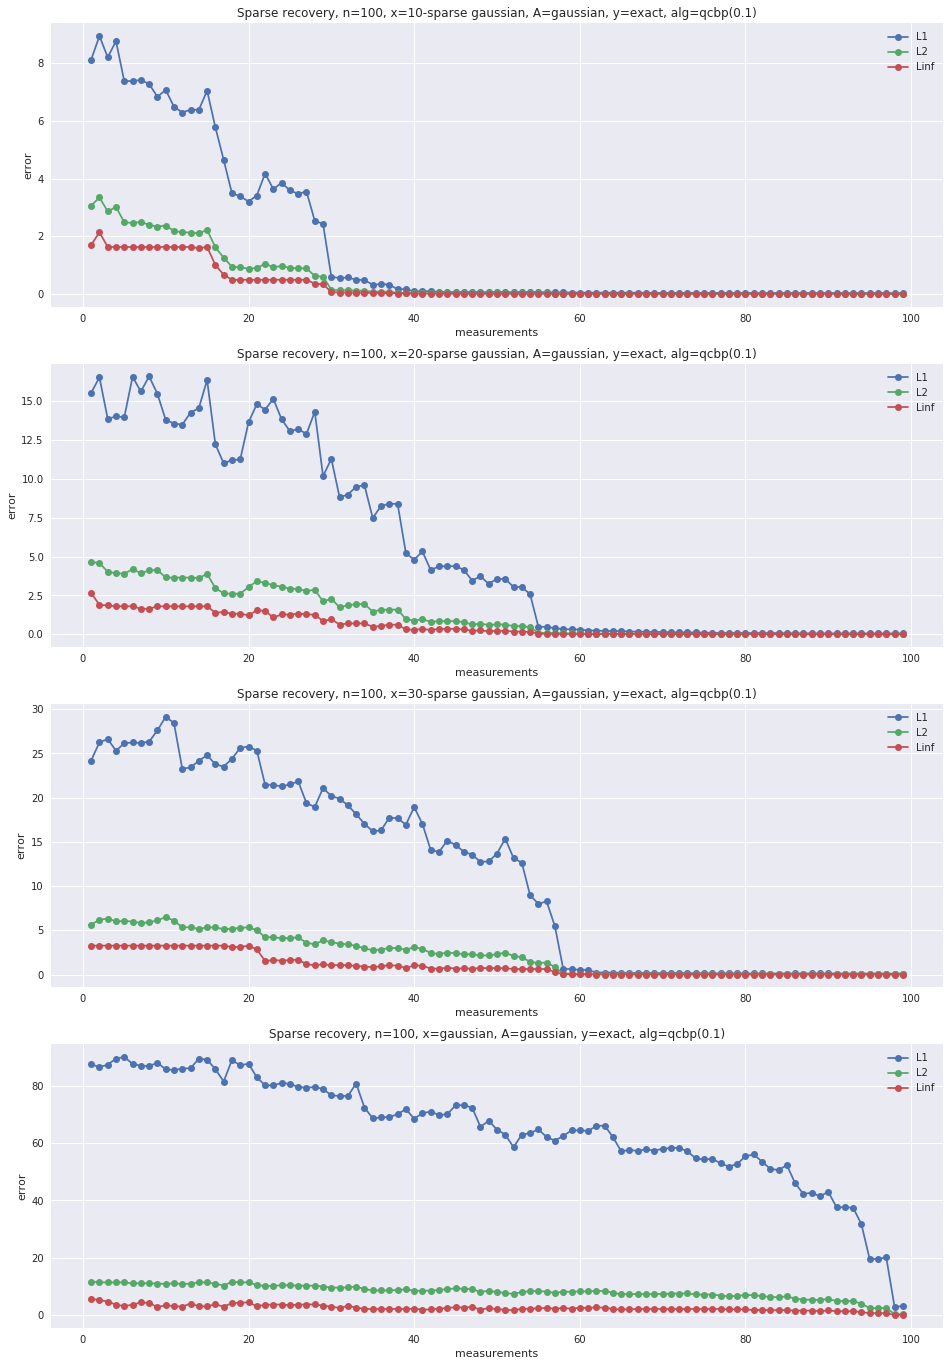

In [34]:
experiment_grid({
    'n': 100, 'm': 99,
    'measurement_samples': 50,
    'A': { 'type': 'gaussian' },
    'y': { 'type': 'exact' },
    'alg': { 'type': 'qcbp', 'eta': 1e-1 },
}, [
    { 'x': { 'type': 'gaussian', 'truncate': 10 } },
    { 'x': { 'type': 'gaussian', 'truncate': 20 } },
    { 'x': { 'type': 'gaussian', 'truncate': 30 } },
    { 'x': { 'type': 'gaussian', 'truncate': None } },
])

Once we use a Gaussian vector, which is not sparse, recovery becomes much tougher.

1 measurements for n=100, x=20-sparse exp(1)^3, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 52.83it/s] 
1 measurements for n=100, x=20-sparse exp(1)^5, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 54.12it/s] 
1 measurements for n=100, x=exp(1)^3, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 55.87it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 54.08it/s] 


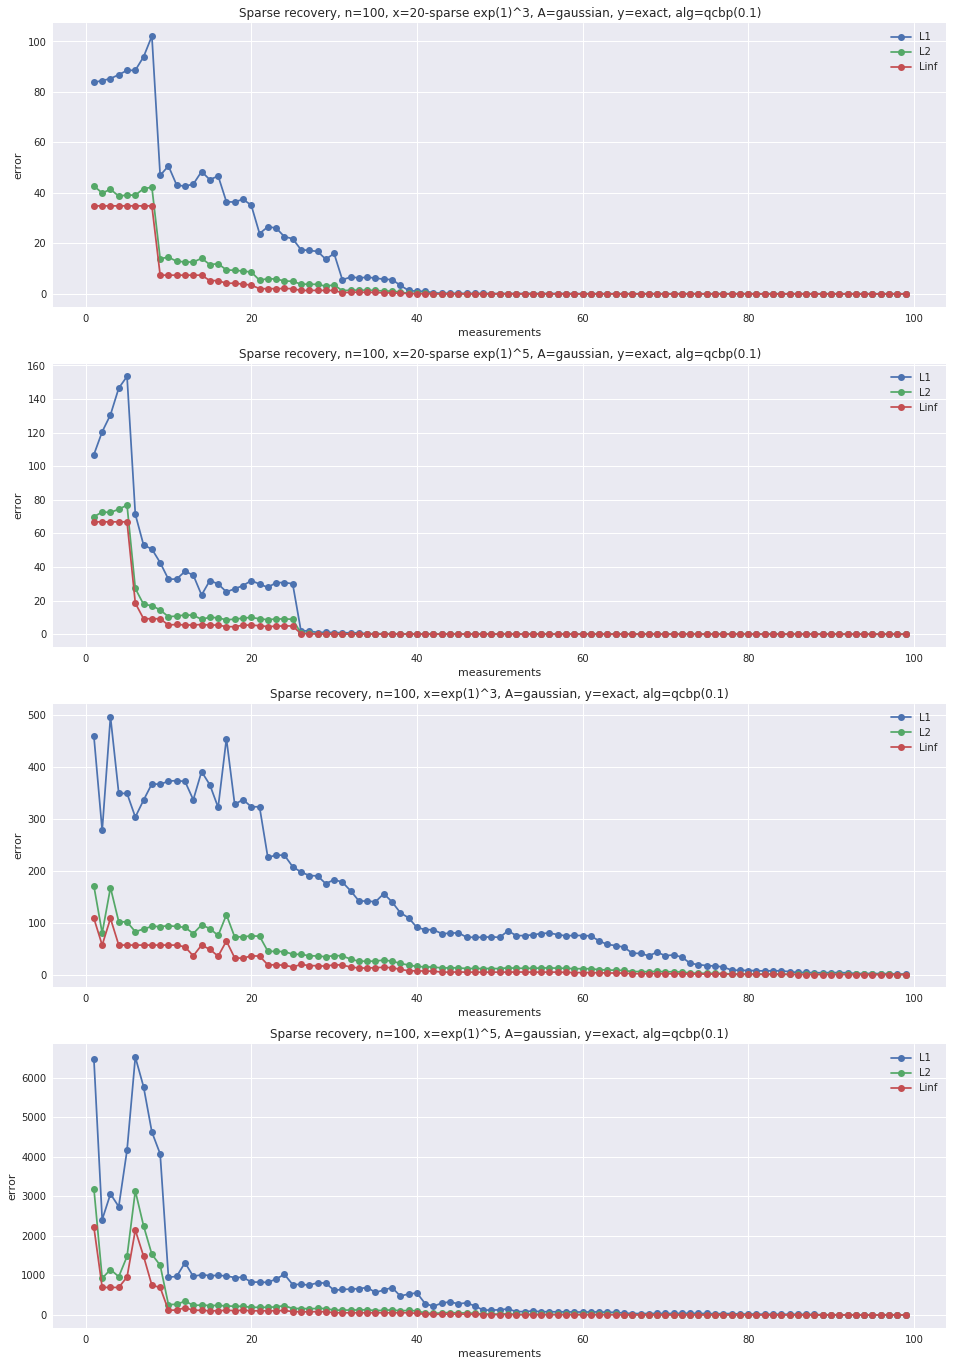

In [35]:
experiment_grid({
    'n': 100, 'm': 99,
    'measurement_samples': 50,
    'A': { 'type': 'gaussian' },
    'y': { 'type': 'exact' },
    'alg': { 'type': 'qcbp', 'eta': 1e-1 },
}, [
    { 'x': { 'type': 'exponential', 'truncate': 20, 'scale': 1, 'power': 3 } },
    { 'x': { 'type': 'exponential', 'truncate': 20, 'scale': 1, 'power': 5 } },
    { 'x': { 'type': 'exponential', 'truncate': None, 'scale': 1, 'power': 3 } },
    { 'x': { 'type': 'exponential', 'truncate': None, 'scale': 1, 'power': 5 } },
])

Low-sparsity-defect truncated vectors do much better.

## Measurement noise

1 measurements for n=100, x=exp(1)^5, A=gaussian, y=exact, alg=bp: : 99it [00:01, 70.71it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=gaussian(1), alg=bp: : 99it [00:01, 74.41it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 54.14it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=gaussian(1), alg=qcbp(0.1): : 99it [00:01, 52.51it/s] 


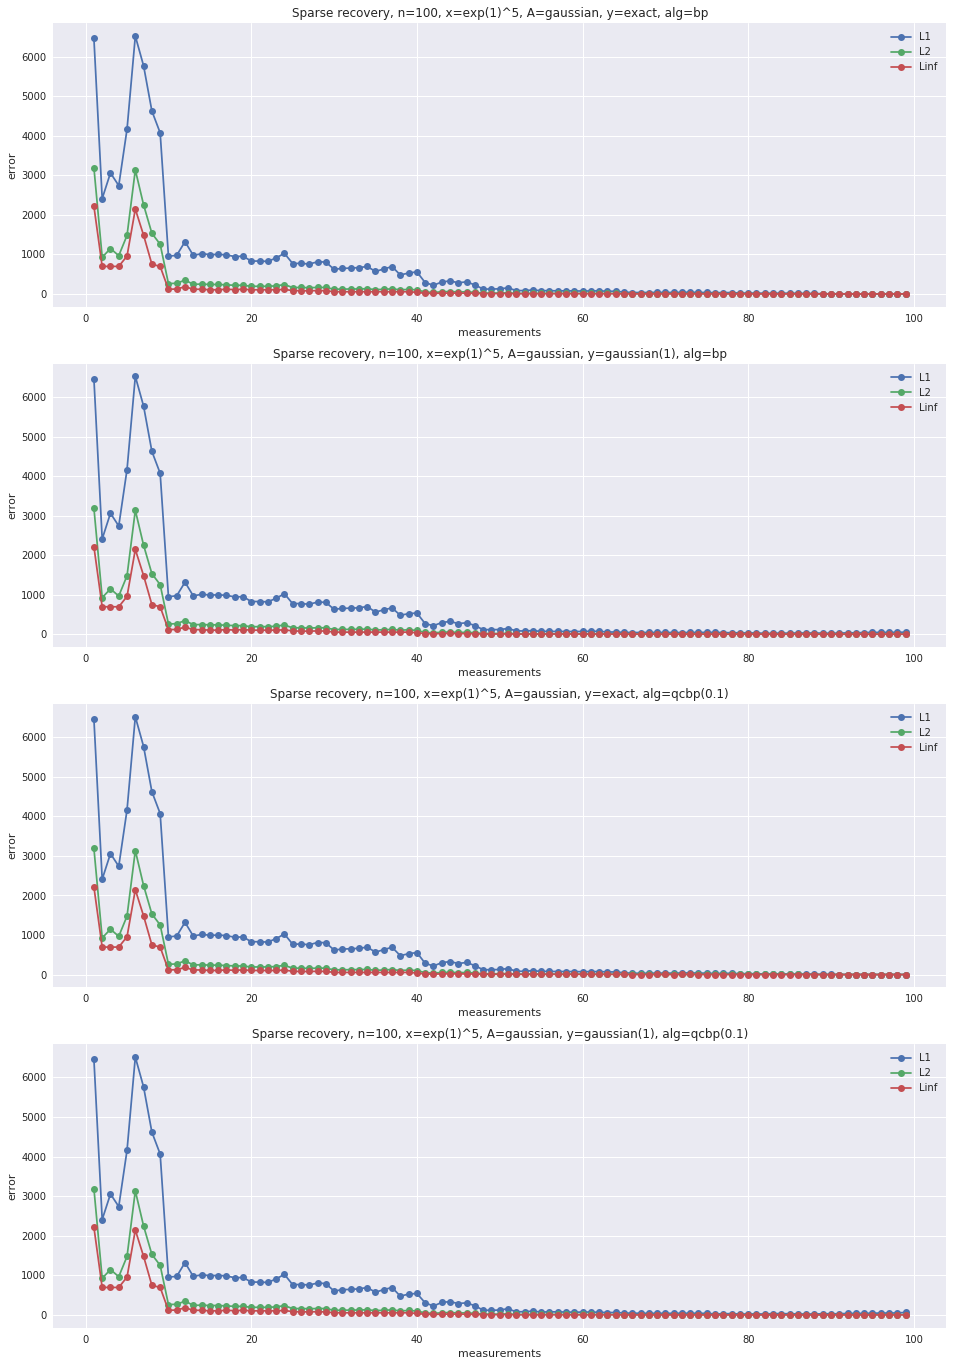

In [37]:
experiment_grid({
    'n': 100, 'm': 99,
    'measurement_samples': 50,
    'x': { 'type': 'exponential', 'truncate': None, 'scale': 1, 'power': 5 },
    'A': { 'type': 'gaussian' },
    'alg': { 'type': 'qcbp', 'eta': 1e-1 },
}, [
    { 'y': { 'type': 'exact' }, 'alg': { 'type': 'bp' } },
    { 'y': { 'type': 'gaussian', 'sigma': 1 }, 'alg': { 'type': 'bp' } },
    { 'y': { 'type': 'exact' } },
    { 'y': { 'type': 'gaussian', 'sigma': 1 }, },
])

Noise has no effect on low-sparsity-defect vector recovery?

1 measurements for n=100, x=exp(1)^5, A=gaussian, y=exact, alg=qcbp(0.1): : 99it [00:01, 52.43it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=gaussian(1), alg=qcbp(0.1): : 99it [00:01, 52.75it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=gaussian(10), alg=qcbp(0.1): : 99it [00:01, 54.06it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=gaussian(100), alg=qcbp(0.1): : 99it [00:01, 56.92it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=gaussian(1000), alg=qcbp(0.1): : 99it [00:01, 61.45it/s] 


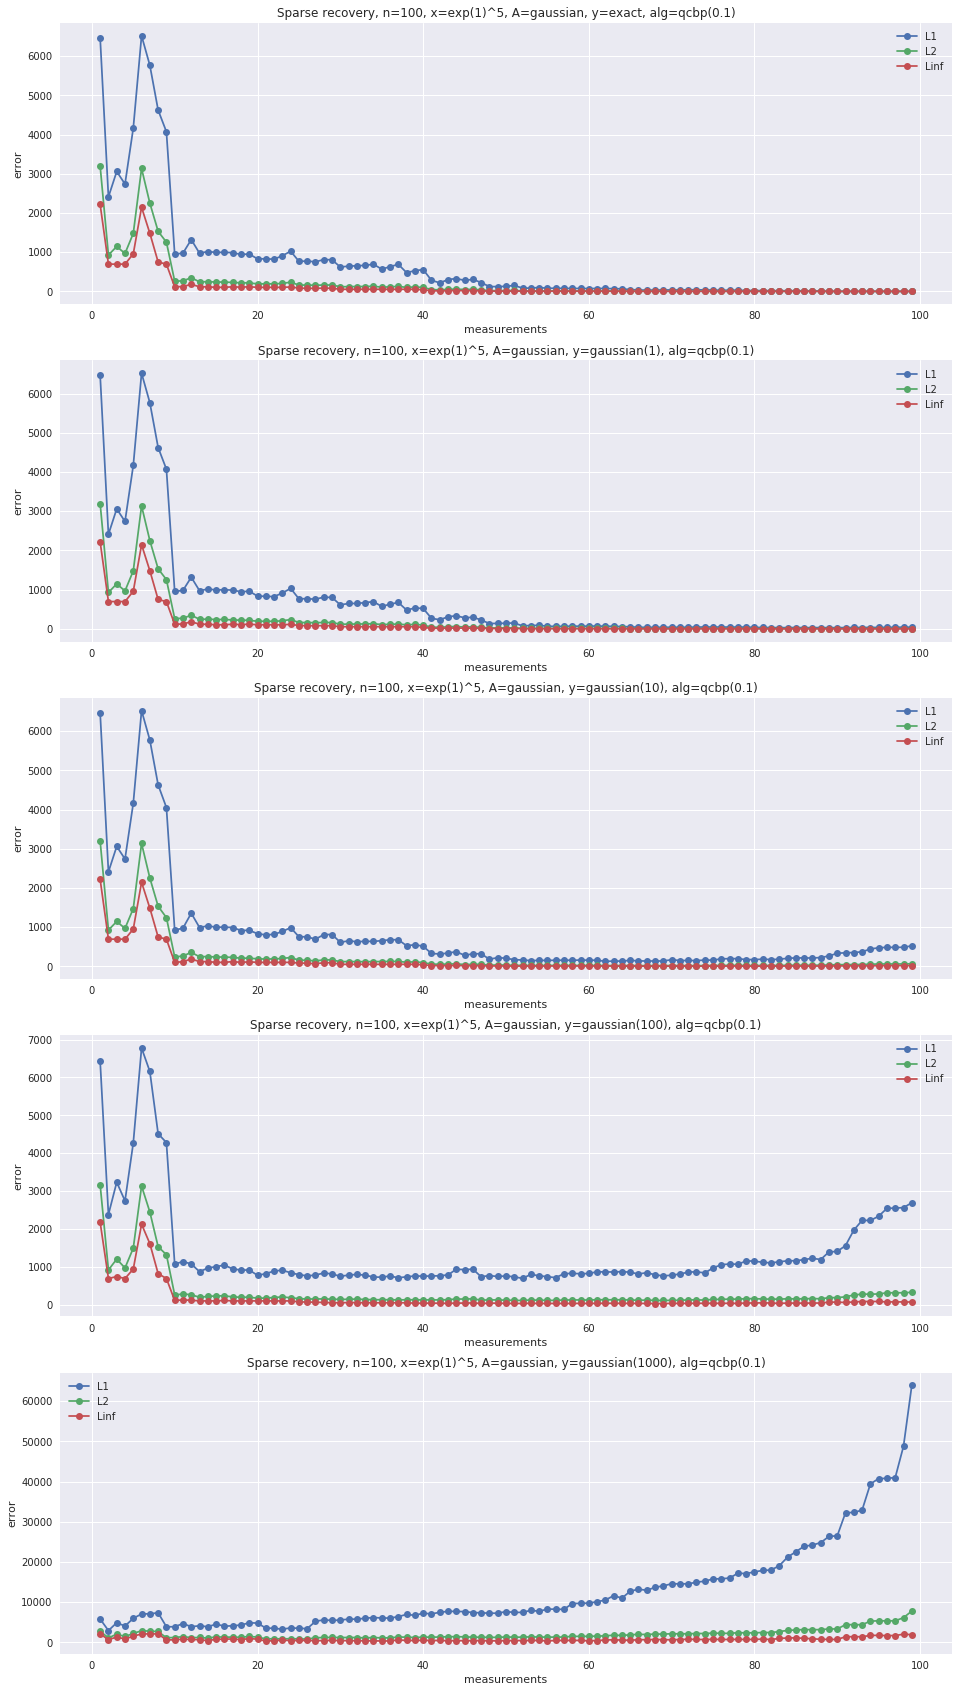

In [40]:
experiment_grid({
    'n': 100, 'm': 99,
    'measurement_samples': 50,
    'x': { 'type': 'exponential', 'truncate': None, 'scale': 1, 'power': 5 },
    'A': { 'type': 'gaussian' },
    'alg': { 'type': 'qcbp', 'eta': 1e-1 },
}, [
    { 'y': { 'type': 'exact' } },
    { 'y': { 'type': 'gaussian', 'sigma': 1 }, },
    { 'y': { 'type': 'gaussian', 'sigma': 10 }, },
    { 'y': { 'type': 'gaussian', 'sigma': 100 }, },
    { 'y': { 'type': 'gaussian', 'sigma': 1000 }, },
])

Noise only affects measurement if its magnitude is sufficiently large. We also finally get the L1-error increasing behavior! There's an threshold for when the system is "overdetermined", which drops as noise increases. This makes sense because QCBP is effectively defining confidence intervals.

1 measurements for n=100, x=exp(1)^5, A=10-subset, y=exact, alg=qcbp(0.1): : 99it [00:00, 141.99it/s] 
1 measurements for n=100, x=exp(1)^5, A=10-subset, y=gaussian(1), alg=qcbp(0.1): : 99it [00:00, 146.43it/s] 
1 measurements for n=100, x=exp(1)^5, A=10-subset, y=gaussian(10), alg=qcbp(0.1): : 99it [00:00, 149.91it/s] 
1 measurements for n=100, x=exp(1)^5, A=10-subset, y=gaussian(100), alg=qcbp(0.1): : 99it [00:00, 160.81it/s] 
1 measurements for n=100, x=exp(1)^5, A=10-subset, y=gaussian(1000), alg=qcbp(0.1): : 99it [00:00, 150.41it/s] 


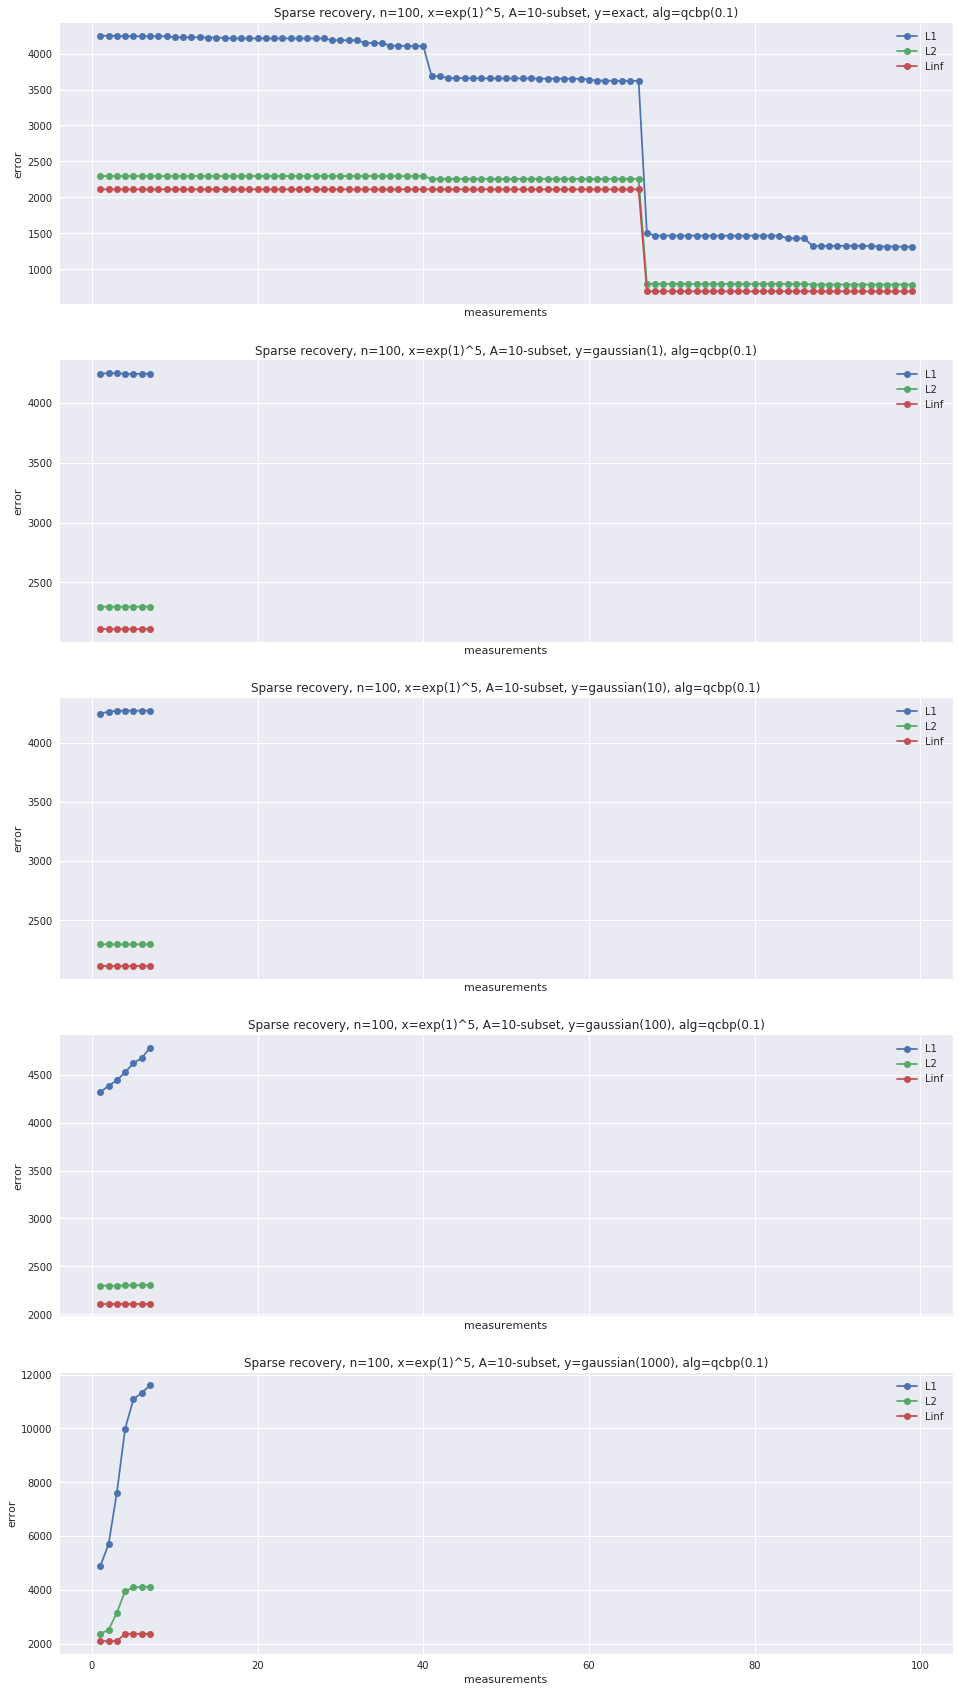

In [51]:
experiment_grid({
    'n': 100, 'm': 99,
    'measurement_samples': 50,
    'x': { 'type': 'exponential', 'truncate': None, 'scale': 1, 'power': 5 },
    'A': { 'type': 'subset', 'k': 10 },
    'alg': { 'type': 'qcbp', 'eta': 1e-1 },
}, [
    { 'y': { 'type': 'exact' } },
    { 'y': { 'type': 'gaussian', 'sigma': 1 }, },
    { 'y': { 'type': 'gaussian', 'sigma': 10 }, },
    { 'y': { 'type': 'gaussian', 'sigma': 100 }, },
    { 'y': { 'type': 'gaussian', 'sigma': 1000 }, },
])

Random-subset matrices fare terribly in the noisy setting, and are not even able to recover the vectors.

## Measurement matrices

1 measurements for n=100, x=exp(1)^5, A=uniform, y=gaussian(100), alg=qcbp(0.1): : 99it [00:01, 52.91it/s] 
1 measurements for n=100, x=exp(1)^5, A=gaussian, y=gaussian(100), alg=qcbp(0.1): : 99it [00:01, 54.36it/s] 
1 measurements for n=100, x=exp(1)^5, A=bounded-gaussian, y=gaussian(100), alg=qcbp(0.1): : 99it [00:01, 53.97it/s] 
1 measurements for n=100, x=exp(1)^5, A=binary, y=gaussian(100), alg=qcbp(0.1): : 99it [00:01, 78.42it/s] 
1 measurements for n=100, x=exp(1)^5, A=5-subset, y=gaussian(100), alg=qcbp(0.1): : 99it [00:00, 156.21it/s] 
1 measurements for n=100, x=exp(1)^5, A=10-subset, y=gaussian(100), alg=qcbp(0.1): : 99it [00:00, 157.13it/s] 
1 measurements for n=100, x=exp(1)^5, A=15-subset, y=gaussian(100), alg=qcbp(0.1): : 99it [00:00, 151.17it/s] 
1 measurements for n=100, x=exp(1)^5, A=25-subset, y=gaussian(100), alg=qcbp(0.1): : 99it [00:00, 160.05it/s] 


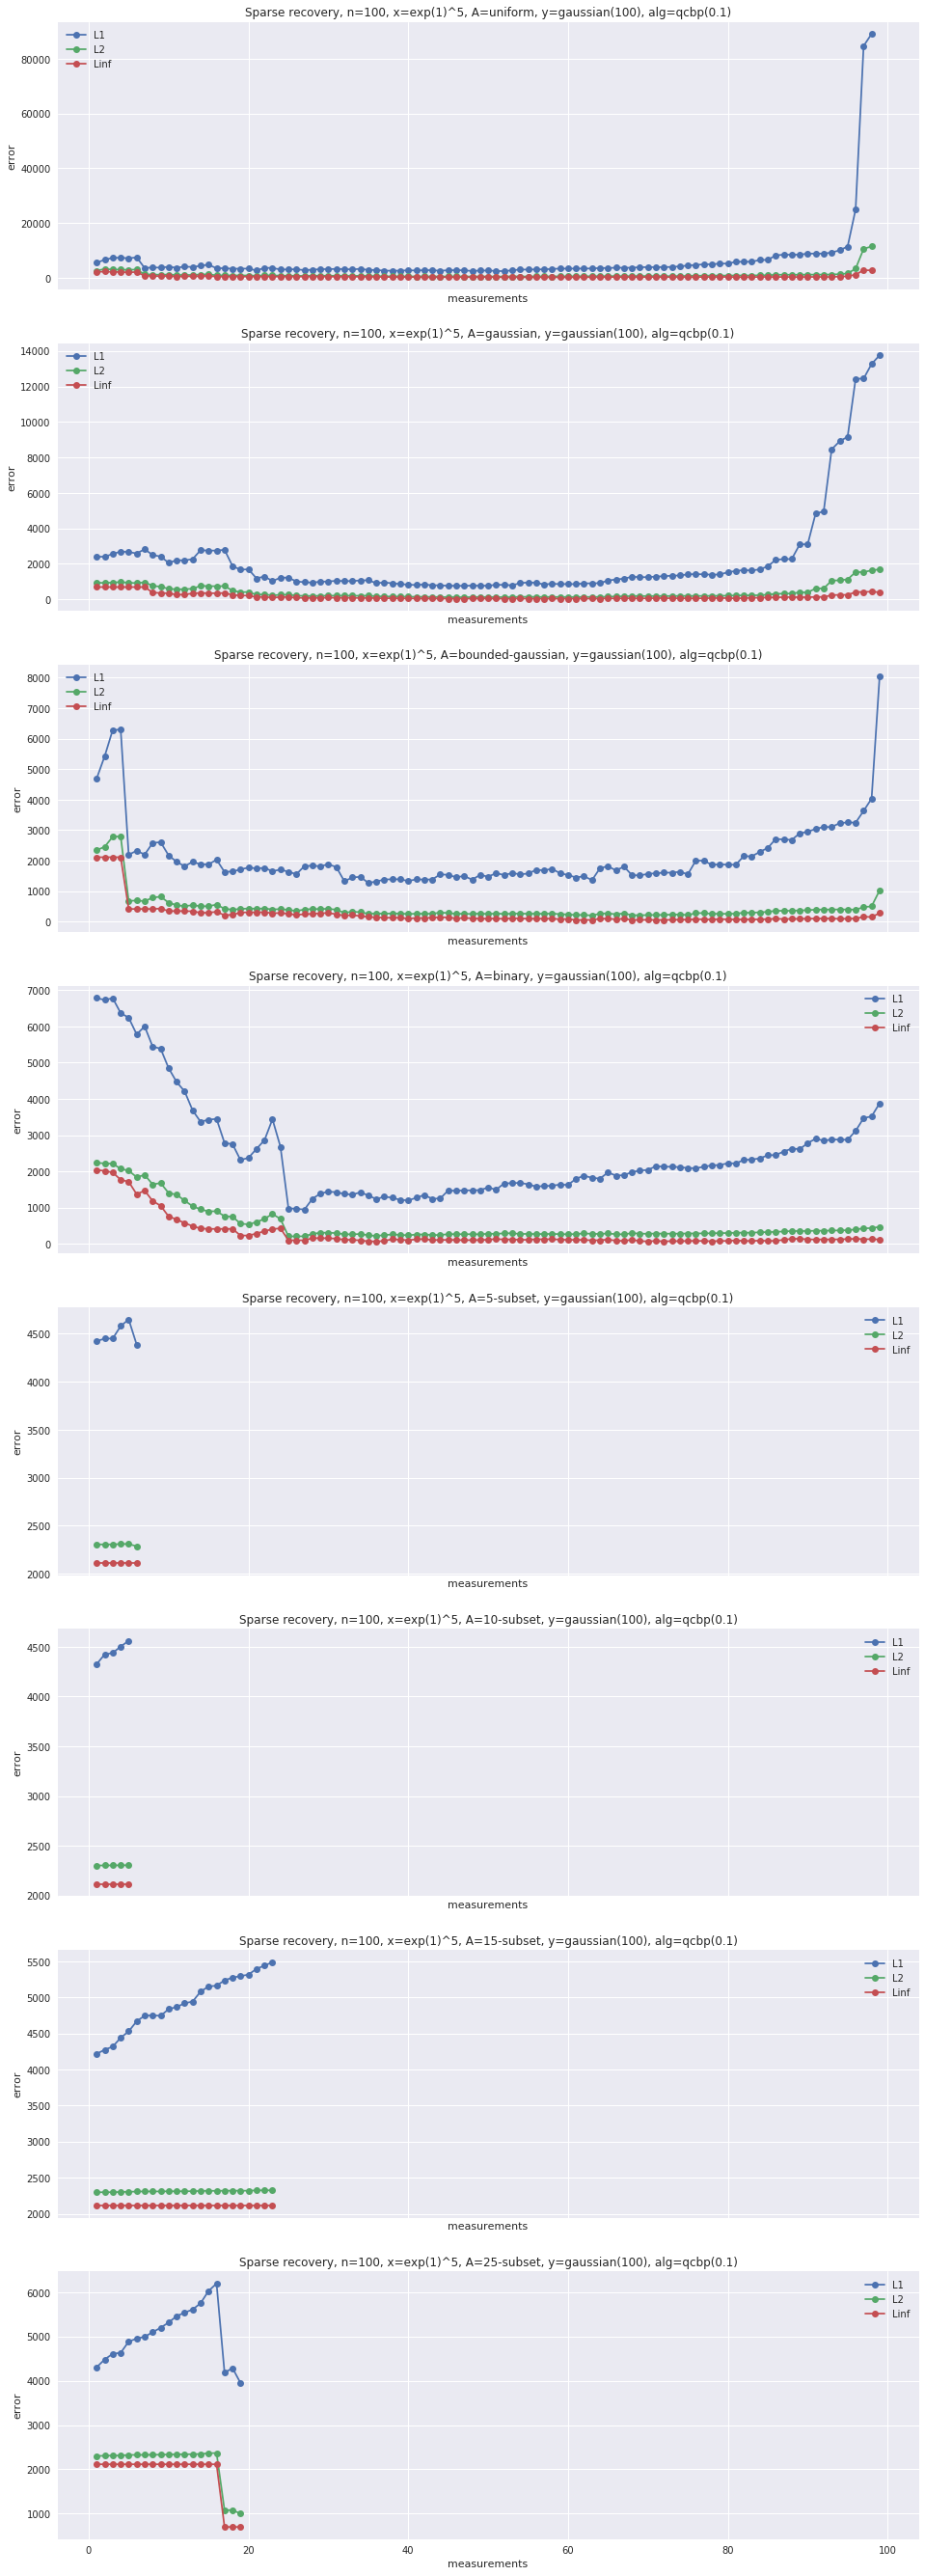

In [55]:
experiment_grid({
    'n': 100, 'm': 99,
    'measurement_samples': 50,
    'x': { 'type': 'exponential', 'truncate': None, 'scale': 1, 'power': 5 },
    'y': { 'type': 'gaussian', 'sigma': 100 },
    'alg': { 'type': 'qcbp', 'eta': 1e-1 },
}, [
    { 'A': { 'type': 'uniform' }, },
    { 'A': { 'type': 'gaussian' }, },
    { 'A': { 'type': 'bounded-gaussian' }, },
    { 'A': { 'type': 'binary' }, },
    { 'A': { 'type': 'subset', 'k': 5 }, },
    { 'A': { 'type': 'subset', 'k': 10 }, },
    { 'A': { 'type': 'subset', 'k': 15 }, },
    { 'A': { 'type': 'subset', 'k': 25 }, },
])

Literally any other type of matrix would be better, even random binary matrices.